# Text Summarizer

[![Twitter Follow](https://img.shields.io/twitter/follow/dialhaseeb?style=social)](www.twitter.com/dialhaseeb)

![Logo](https://github.com/zenyc/zenyc/blob/master/logo-small.png)

## 🕯 About
**text-summarizer** is a *machine learning model* that does an abstractive summarization of the text provided to it. It uses Deep Learning techniques to do so.


## Before we beigin, let's cofigure some stuff so that the notebook runs both on your local machine and on *Google's Colaboratory*

1- If you are running locally, run the following cell:

In [ ]:
proj_dir = "proj-dir/"

2- If you are running on *Colab*, 
- Make sure you have uploaded all the project files to your *Google Drive*. Then, mount your drive by running the following cell:

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


- Then write out the path to the project files relative to your drive's root directory after `/content/drive/My Drive/` in the following cell:

In [2]:
%cd "/content/drive/My Drive/Projects/text-summarizer/"
proj_dir = "proj-dir/"

/content/drive/My Drive/Projects/text-summarizer


## Next up, let's import everything we need. Run the following:

In [3]:
from attention import AttentionLayer

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras import backend as K 

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Read the dataset:

In [5]:
data=pd.read_csv("proj-dir/Reviews.csv")

# Drop Duplicates and NA values

In [6]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

# Information about dataset

Let us look at datatypes and shape of the dataset

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393565 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      393565 non-null  int64 
 1   ProductId               393565 non-null  object
 2   UserId                  393565 non-null  object
 3   ProfileName             393565 non-null  object
 4   HelpfulnessNumerator    393565 non-null  int64 
 5   HelpfulnessDenominator  393565 non-null  int64 
 6   Score                   393565 non-null  int64 
 7   Time                    393565 non-null  int64 
 8   Summary                 393565 non-null  object
 9   Text                    393565 non-null  object
dtypes: int64(5), object(5)
memory usage: 33.0+ MB


## Preprocessing:

In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
    "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"}

In [9]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:            #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [10]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

Let us look at the first 3 preprocessed reviews

In [11]:
cleaned_text[:3]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch']

In [12]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

Let us look at the first 3 preprocessed summaries

In [13]:
cleaned_summary[:3]

['good quality dog food', 'not as advertised', 'delight says it all']

In [14]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

#Dropping empty rows:

In [15]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

#Understanding the distribution of the sequence lenghts:

        text  summary
0         23        4
1         18        3
2         39        4
3         17        2
4         13        2
...      ...      ...
393208    12        4
393209    22        1
393210    37        4
393211    18        5
393212     9        2

[393213 rows x 2 columns]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f53b3258c18>,
      dtype=object)

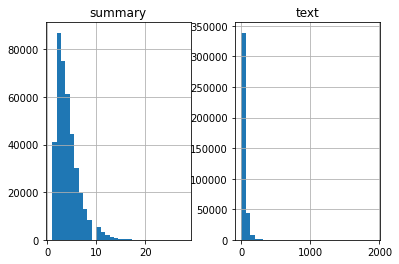

In [16]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

print(length_df)
length_df.hist(bins = 30)

Let's fix the maximum length of the summary to 8.

In [17]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9458130834941876


94% of the summaries have length below 8. So, we can fix maximum length of summary to 8.

Let us fix the maximum length of review to 30

In [18]:
max_text_len=30
max_summary_len=8

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [19]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

## Adding END and START tokens:

In [20]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

## Splitting Data into Train and Test Sets:

In [21]:
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

#Preparing the Tokenizers

In [22]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

#Finding rare Words:

Let us set the threshold to be 4 which means word whose count is below 4 is considered as a rare word

In [23]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt+=1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 68.11028647495395
Total Coverage of rare words: 1.4450730144421176


## Let us define the tokenizer with top most common words for reviews:

In [24]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [25]:
x_voc

17489

## Now the Summary Tokenizer

In [26]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

# Finding rare Words

In [27]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 75.99750324098527
Total Coverage of rare words: 2.592810080219758


Let us define the tokenizer with top most common words for summary.

In [28]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

Let's do a sanity check by seeing whether word count of start token is equal to length of the training data

In [29]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(192402, 192402)

## Let's now see how much training and validation data we have:

In [30]:
x_tr.shape, y_tr.shape, x_val.shape, y_val.shape

((192402, 30), (192402, 8), (21379, 30), (21379, 8))

Here, I am deleting the rows that contain only **START** and **END** tokens

In [31]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [32]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Building the model:

In [33]:
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)




decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary(300)

Model: "functional_1"
____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                                                       Output Shape                                                      Param #                             Connected to                                                                                       
input_1 (InputLayer)                                                                               [(None, 30)]                                                      0                                                                                                                                      
___________________________________________________________________________

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [35]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

## Training the model:

In [36]:
x_tr.shape, y_tr.shape, x_val.shape, y_val.shape

((189522, 30), (189522, 8), (21051, 30), (21051, 8))

In [37]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
1481/1481 [==============================] - 642s 434ms/step - loss: 2.7165 - val_loss: 2.4521
Epoch 2/50
1481/1481 [==============================] - 642s 434ms/step - loss: 2.3940 - val_loss: 2.2968
Epoch 3/50
1481/1481 [==============================] - 641s 433ms/step - loss: 2.2798 - val_loss: 2.2168
Epoch 4/50
1481/1481 [==============================] - 656s 443ms/step - loss: 2.2120 - val_loss: 2.1658
Epoch 5/50
1481/1481 [==============================] - 647s 437ms/step - loss: 2.1628 - val_loss: 2.1318
Epoch 6/50
1481/1481 [==============================] - 650s 439ms/step - loss: 2.1280 - val_loss: 2.1017
Epoch 7/50
1481/1481 [==============================] - 648s 438ms/step - loss: 2.1010 - val_loss: 2.0874
Epoch 8/50
1481/1481 [==============================] - 646s 436ms/step - loss: 2.0824 - val_loss: 2.0731
Epoch 9/50
1481/1481 [==============================] - 643s 434ms/step - loss: 2.0688 - val_loss: 2.0702
Epoch 10/50
1481/1481 [=======================

KeyboardInterrupt: ignored

## Saving the model:


In [45]:
model.save(proj_dir+"trained-new.h5")

#Understanding the Diagnostic plot

Now, we will plot a few diagnostic plots to understand the behavior of the model over time:

In [39]:
plt.plot(history.history['loss'], label='train')
lt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

NameError: ignored

From the plot, we can see that validation loss has increased after epoch 17 for 2 successive epochs. Hence, training is stopped at epoch 19.

## Now, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [40]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

## Loading the saved model:

In [44]:
model = load_model('trained-new.h5', custom_objects={'AttentionLayer': AttentionLayer})

# Inference

Set up the inference for the encoder and decoder:

In [46]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

## We are defining a function below which is the implementation of the inference process:

In [47]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

## Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [48]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

## Let's see the model in action and generate a few summaries:

In [49]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: great think might even better regular brownies good happy found 
Original summary: so good 
Predicted summary:  great brownies


Review: candies soft soft pepermint means melt mouth bite break apart bad sad buy another kind soft peppermint next go around 
Original summary: soft 
Predicted summary:  not so good


Review: love bob red mill products grains blend ground included multigrain bread without grinding home pantry staple house price fantastic 
Original summary: makes great multigrain bread 
Predicted summary:  great bread


Review: think product excellent came quickly used almost buy 
Original summary: excellent product 
Predicted summary:  excellent


Review: quality extract unbelievable results great everyone always says something different makes results better 
Original summary: cake cookies pies 
Predicted summary:  great product


Review: recently started baking bread yeast perfect rises consistantly every time held great frozen 
Original summary: great for bread 
Pr

# The End?

## 👀 Contact

If you want to contact me you can reach me at <zenyc@live.com>.